# **Prediction model**

## Objectives

* Predict future trends in access to electricity, access to clean fuels, and CO₂ emissions by 2030.

* Use linear regression models per country based on historical data (2000–2020) to estimate realistic, explainable future scenarios aligned with SDG 7 targets.

* Ensure interpretability and transparency in the prediction process to support policy communication and public understanding.

## Inputs

* Cleaned dataset from: the previous ETL stage (global-data-on-sustainable-energy-processed.csv)

* Variables used:

*   Time series per country for each target variable

*   Historical values from 2000 to 2020 (at least 5 valid data points per country/target)

*   No socioeconomic projections beyond 2020 are assumed (trend-based forecasting only)

## Outputs

*   Linear Regression models trained individually per country and target variable

*   Forecasted values for the year 2030, exported to:

        * data/predictions_linear_2030.csv

*   Visualisations showing:

    * Predicted distributions per variable

    * Country-level comparison between current and projected values

   




---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\organ\\Desktop\\Code institute\\FINALPROYECTCODE\\SDG7_Proyect\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\organ\\Desktop\\Code institute\\FINALPROYECTCODE\\SDG7_Proyect'

# Import Libraries and Build the model

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv('Data\Processed\global-data-on-sustainable-energy-processed.csv')

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\organ\AppData\Local\Temp\ipykernel_12640\3236192823.py:1: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv('Data\Processed\global-data-on-sustainable-energy-processed.csv')


In [6]:
df.dtypes

country                           object
year                               int64
access_to_electricity            float64
access_to_clean_fuels            float64
renewable_capacity_per_capita    float64
renewable_energy_share           float64
fossil_electricity               float64
nuclear_electricity              float64
renewable_electricity            float64
low_carbon_electricity_pct       float64
primary_energy_per_capita        float64
energy_intensity                 float64
co2_emissions_kt                 float64
gdp_growth                       float64
gdp_per_capita                   float64
dtype: object

# Create a predictive model using linear regresion

In [ ]:
sns.set_style("whitegrid")

# Variables to predict
target_vars = [
    'access_to_electricity',
    'access_to_clean_fuels',
    'co2_emissions_kt',
    'renewable_capacity_per_capita'  
]
year_future = 2030

# Prepare predictions and metrics
predictions = []
metrics = []

# Loop through countries and predict each target
for country in df['country'].unique():
    df_country = df[df['country'] == country]

    for target in target_vars:
        df_target = df_country[['year', target]].dropna()

        if len(df_target) >= 5:  # Ensure minimum data points
            X = df_target[['year']]
            y = df_target[target]

            model = LinearRegression()
            model.fit(X, y)
            y_pred = model.predict(X)

            # Predict future
            future_input = pd.DataFrame({'year': [year_future]})
            future_pred = model.predict(future_input)[0]

            # Apply bounds for % variables
            if target in ['access_to_electricity', 'access_to_clean_fuels']:
                future_pred = min(100, max(0, future_pred))
            elif target == 'renewable_capacity_per_capita':
                future_pred = max(0, future_pred)  # prevent negative capacity

            predictions.append({
                'country': country,
                'target': target,
                'predicted_value_2030': future_pred
            })

            # Metrics
            r2 = r2_score(y, y_pred)
            mae = mean_absolute_error(y, y_pred)
            metrics.append({
                'country': country,
                'target': target,
                'r2': r2,
                'mae': mae
            })

# Convert to DataFrame
df_predictions = pd.DataFrame(predictions)
df_metrics = pd.DataFrame(metrics)

# Pivot to wide format for exporting or dashboard
df_2030 = df_predictions.pivot(index='country', columns='target', values='predicted_value_2030').reset_index()
df_2030['year'] = year_future

# Save to CSV
df_2030.to_csv("Data/Predictions/predictions_linear_2030.csv", index=False)

# Print metrics summary
print("Performance Metrics promedio por variable:")
for target in target_vars:
    sub_df = df_metrics[df_metrics['target'] == target]

    if sub_df.empty:
        print(f"\n{target}: no hay métricas registradas.")
        continue

    mae_avg = sub_df['mae'].mean()
    r2_avg = sub_df['r2'].mean()

    print(f"\n{target}:")
    print(f"  MAE promedio: {mae_avg:.2f}")
    print(f"  R² promedio : {r2_avg:.2f}")





Performance Metrics promedio por variable:

access_to_electricity:
  MAE promedio: 0.96
  R² promedio : 0.80

access_to_clean_fuels:
  MAE promedio: 0.58
  R² promedio : 0.89

co2_emissions_kt:
  MAE promedio: 17470.69
  R² promedio : 0.47

renewable_capacity_per_capita:
  MAE promedio: 9.79
  R² promedio : 0.75


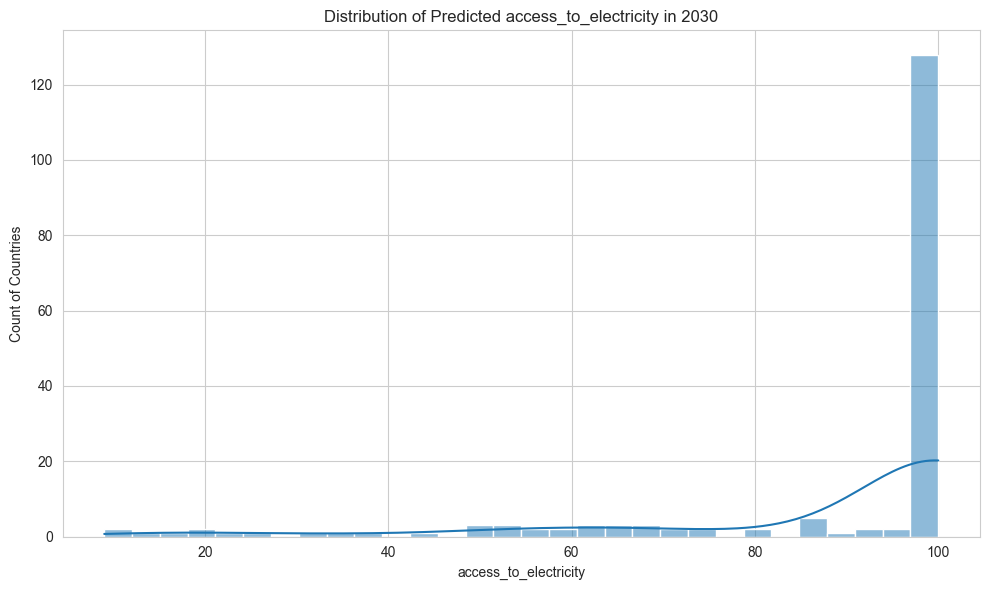

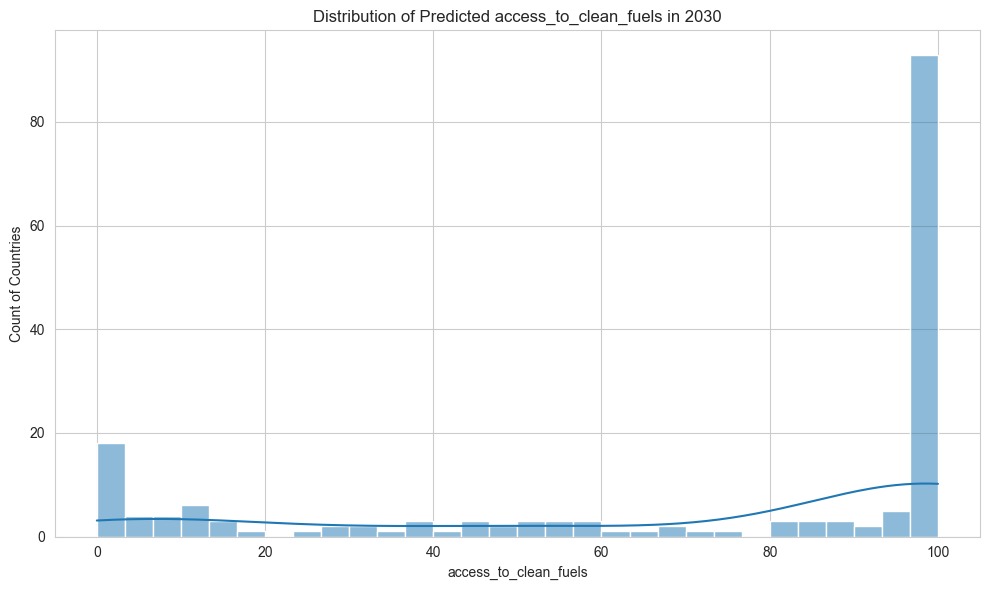

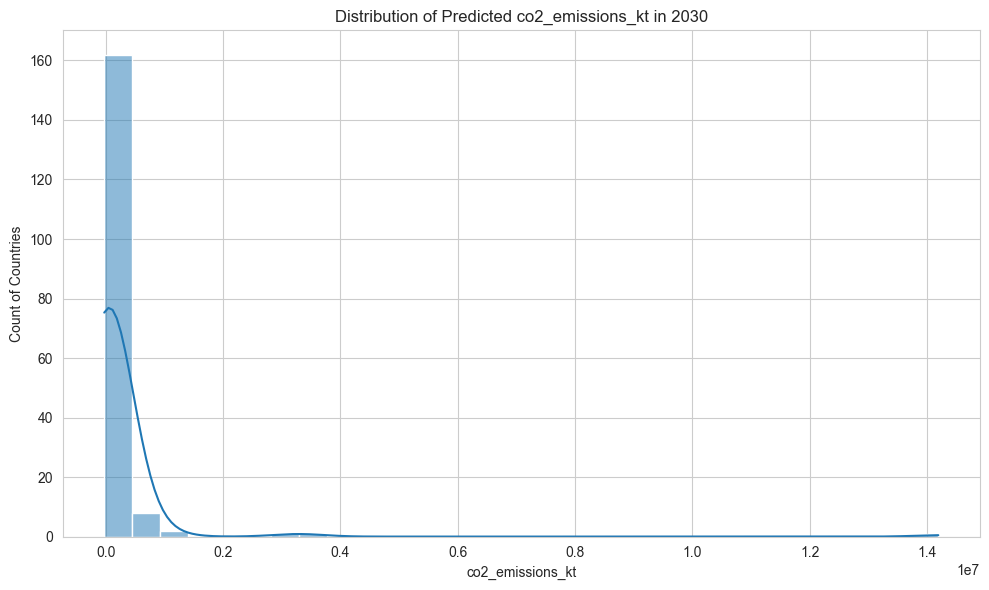

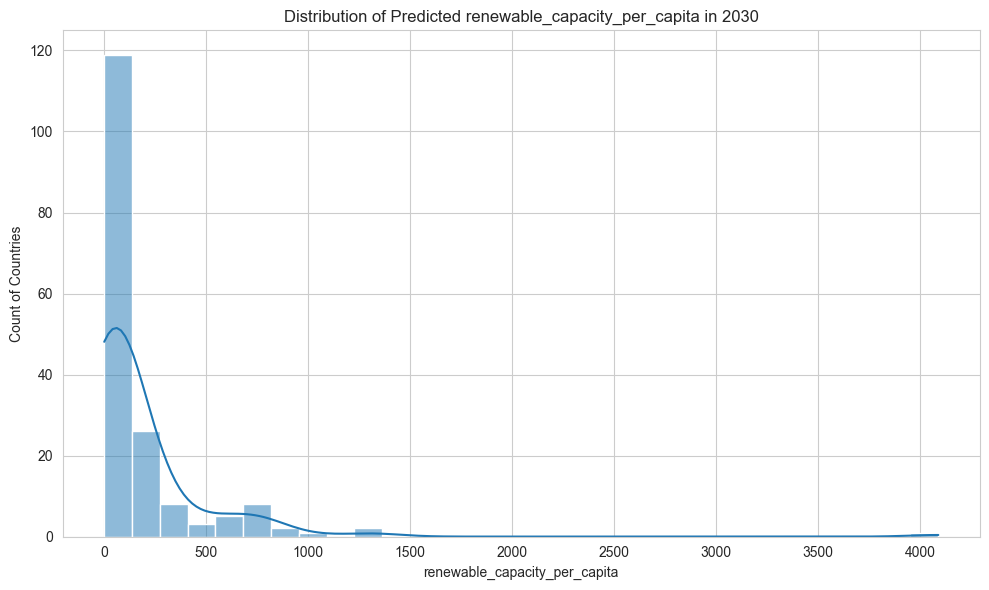

In [11]:
# Histograms of predictions
for target in target_vars:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_2030[target], kde=True, bins=30)
    plt.title(f"Distribution of Predicted {target} in 2030")
    plt.xlabel(target)
    plt.ylabel("Count of Countries")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [9]:
# Save results
df_pred = pd.DataFrame(predictions)
df_2030 = df_pred.pivot(index='country', columns='target', values='predicted_value_2030').reset_index()
df_2030['year'] = year_future
df_2030.to_csv("data/Predictions/predictions_linear_2030.csv", index=False)
print("Predictions saved to data/predictions_linear_2030.csv")


Predictions saved to data/predictions_linear_2030.csv


## Model Justification: Linear Regression per Country (2030 Predictions)

For this project, I used **simple linear regression models** applied **individually per country and per target variable** (`access_to_electricity`, `access_to_clean_fuels`, `co2_emissions_kt`). This approach was chosen based on the following reasons:

 **Interpretability**: Linear regression is transparent and easy to explain. Each country has its own model, making it straightforward to analyze and validate.

 **Data Availability**: The dataset contains historical time series per country from ~2000 to 2020, making linear trends a reasonable first assumption.

 **Project Requirements**: The model provides clear numerical predictions for 2030, aligned with the SDG 7 goal year.
 
 **Simplicity and Scalability**: Running many small linear models is computationally light and allows prediction coverage for over 170 countries.


### Limitations of the Model

While linear regression offers clarity and speed, it has some key limitations:

**Oversimplification**: It assumes a linear relationship between the year and the target variable, which may not hold true for all countries or contexts.

**Univariate Dependence**: The model only uses the year as an explanatory variable, ignoring other important factors (e.g., GDP, energy policy, urbanization).

**Low Reliability in CO₂ Predictions**: The model for `co2_emissions_kt` shows weak performance (average R² ≈ 0.47), meaning the predictions should be interpreted with caution.

 **Data Gaps and Quality**: Countries with less than 5 data points were excluded to maintain a minimal baseline of reliability, but this introduces uneven coverage.

### Ethical Considerations

**Transparency**: The model and its metrics are shared openly, and limitations are documented. No hidden logic or black-box modeling was used.

**Fair Representation**: Each country is modeled independently to avoid biasing predictions in favor of higher-income nations.

**No Policy Forecasting**: These predictions are statistical extrapolations, **not forecasts** based on political, environmental, or technological changes. Misinterpreting them as such could lead to flawed conclusions.

**Avoiding Misuse**: The predictions should not be used to rank countries' efforts or assign blame. They reflect historical trends, not intent or capability.


---

---

# Push files to Repo

* In cases where you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [10]:
import os
try:
  # create your folder here
  # os.makedirs(name='')
except Exception as e:
  print(e)


IndentationError: expected an indented block after 'try' statement on line 2 (553063055.py, line 5)